### Part 1: Implement the K-means algorithm


In [154]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [155]:
# Import iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data

In [156]:
def kmeans(x, K, n_init):
    """
    Args:
        x: input data
        K: number of centroids
        n_init: the number of initial guesses for the centroids
    Returns:
        centroids: contains the centers of the clusters
        labels: contains the cluster index for each data point
    """
    # Initialize centroids randomly
    centroids = x[np.random.choice(len(x), K, replace=False)]

    labels = np.zeros(len(x))

    while True:  # Run until convergence
        prev_labels = labels.copy()

        # Assign data points to the nearest centroid
        distances = np.linalg.norm(x[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Update centroids
        centroids = np.array([np.mean(x[labels == k], axis=0) if np.sum(labels == k) > 0 else np.random.rand(x.shape[1]) for k in range(K)])

        # Check for convergence
        if np.array_equal(prev_labels, labels):
            break

    return centroids, labels



https://www.askpython.com/python/examples/k-means-clustering-from-scratch

In [157]:
centroids, labels = kmeans(X, 3, 1000)

print("Centroids:")
print(centroids)
print()
print("Labels:")
print(labels)

Centroids:
[[6.85       3.07368421 5.74210526 2.07105263]
 [5.006      3.428      1.462      0.246     ]
 [5.9016129  2.7483871  4.39354839 1.43387097]]

Labels:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]


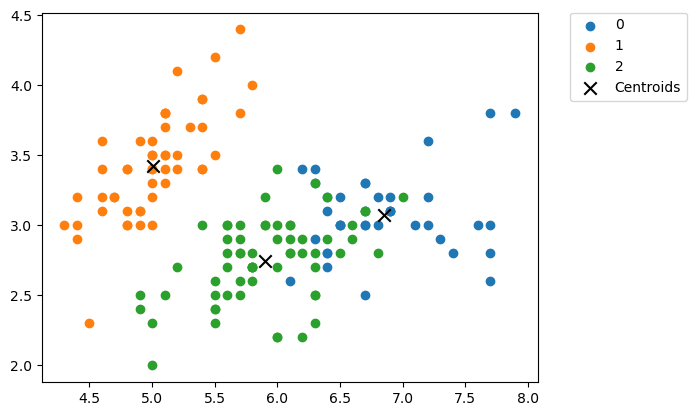

In [158]:
# Visualize the results
u_labels = np.unique(labels)
for i in u_labels:
    plt.scatter(X[labels == i, 0], X[labels == i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color="black", label="Centroids", marker="x")
plt.legend(bbox_to_anchor=(1.3, 1), borderaxespad=0)
plt.show()


### *If you run this algorithm multiple times, do you get the same result every time? If so, why; if not, how do you determine which result is the best one?*

If we run this algorithm multiple times, we will not get the same result every time. This is because the sensitivity to the initial centroids, so the algorithm will converge to different local minima, that is, different initilizations of the centroids will lead to a different local minima. To determine which result is the best one, we can use the elbow method to determine the optimal number of clusters. The elbow method involves plotting the sum of squared errors (SSE) for different values of K. The elbow in the curve indicates the optimal value of K.


### *How do you choose what K value to use?*
The Elbow Method involves plotting the sum of squared errors (SSE) for different values of K. The elbow in the curve indicates the optimal value of K. The optimal K value is the value that is at the inflection point on the curve where the SSE begins to decrease in a linear way. It consists of the following steps:
1. Run the K-means clustering algorithm for a range of K values (e.g. K=1 to 10)
2. For each value of K, calculate the sum of squared errors (SSE)
3. Plot SSE vs K (number of clusters)
4. Identify the elbow in the plot (the point where the SSE curve starts to bend) and select this as the best K value for the data.

Another method is the Silhouette method. The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster. If many points have a negative Silhouette value, it may indicate that we have created too many or too few clusters.

### *Implement both SSE and the Silhouette score; use them to address these questions.*


In [159]:
# Implementing SSE
def calculate_sse(x, centroids, labels):
    sse = np.sum((x - centroids[labels])**2)
    return sse

In [160]:
# Calculate SSE
sse = calculate_sse(X, centroids, labels)
print(f'SSE: {sse}')

SSE: 78.85144142614601


In [161]:
# Elbow Method
def plot_elbow_method(data, max_k, n_init=10):
    sse_values = []

    for k in range(1, max_k + 1):
        sse = 0

        for _ in range(n_init):
            centroids, labels = kmeans(data, k, n_init=10)
            sse += calculate_sse(data, centroids, labels)

        sse_values.append(sse / n_init)

    # Plot
    plt.plot(range(1, max_k + 1), sse_values, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('Elbow Method')
    plt.show()

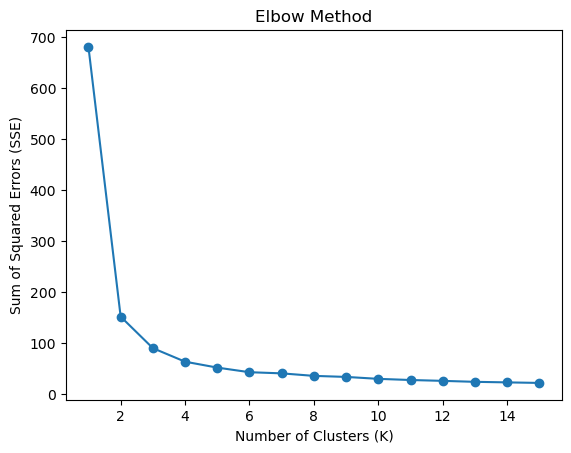

In [162]:
plot_elbow_method(X, 15, n_init=50)

In [163]:
# Implementing the Silhouette Score
def calculate_silhouette_score(x, labels):
    """
    Calculate the silhouette score for a given clustering.

    Args:
        x: input data
        labels: contains the cluster index for each data point

    Returns:
        silhouette: silhouette score
    """
    num_samples = len(x)
    silhouette_values = np.zeros(num_samples)

    for i in range(num_samples):
        # Calculate the average distance from the i-th sample to all other samples in the same cluster
        intra_cluster_dist = np.mean(np.linalg.norm(x[labels == labels[i]] - x[i], axis=1))

        # Calculate the average distance from the i-th sample to all samples in the nearest other cluster
        other_clusters_dist = np.min([np.mean(np.linalg.norm(x[labels == k] - x[i], axis=1)) for k in set(labels) if k != labels[i]])

        # Calculate the silhouette score for the i-th sample
        silhouette_values[i] = (other_clusters_dist - intra_cluster_dist) / max(other_clusters_dist, intra_cluster_dist)

    # Calculate the overall silhouette score
    silhouette = np.mean(silhouette_values)
    
    return silhouette


In [164]:
silhouette = calculate_silhouette_score(X, labels)
print(f'Silhouette Score: {silhouette}')

Silhouette Score: 0.5617085758870528


### *Discuss the similarities and differences between 1) K-means, 2) Gaussian Mixture Models (GMM) and 3) the Gaussian naive Bayes classifier in terms of their assumptions and parameter estimation methods. In particular, write down the implications of each assumption (e.g., x and y are assumed to be independent, and therefore we have ....).  You can choose to write your answers as Python code, pseudo code or mathematical equations.*
**K-means**

Assumptions:

- K-means assumes that clusters are spherical and equally sized with the centroid being the center of the sphere.
- Assumes that all clusters have equal variance (homodedasticity).
- Assigns each data point exclusively to one cluster, which can lead to misclassifications if the true underlying structure involves overlapping clusters.
- The number of clusters is assumed to be known in advance.

Parameter Estimation:
- Centroids: They are estimated by iteratively updating the mean of the data points assigned to each cluster.
- Labels: Assign each data point to the cluster with the nearest centroid.

Implications:
- Clusters with non-spherical shapes can be poorly represented by centroids.
- Variance differences between features can affect the assignment of clusters.
- If clusters have different sizes, K-means might not represent them accurately, preferring clusters with more points.
- Features with much larger variances can dominate the distance metric, making the algorithm biased towards those features.
- The algorithm is sensitive to the initial selection of centroids.
- In real world scenarios, the number of cluster is not known in advance. There is no one defined true number of cluster, it has to be determined from methods, data-based criteria and knowledge of the domain.

**Gaussian Mixture Models (GMM)**:

Assumptions:
- Data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. 
- GMM assumes that clusters can be elliptical and can have different sizes. 
- Within a cluster, the shape of the data is defined by a covariance matrix, which is assumed to be the same for all clusters.
- In GMM, a point can belong to different clusters with different levels of membership (probabilities).

Parameter Estimation:
- Means, Covariances, Weights: Estimated through the Expectation-Maximization (EM) algorithm. The algorithm iteratively updates the mean, covariance, and weight parameters to maximize the likelihood of the data.

Implications:
- GMM can capture more complex cluster structures and sizes, also overlapping clusters.
- GMM is more computationally expensive than K-means.


**Gaussian Naive Bayes Classifier**:
Assumptions:
- Features are assumed to be conditionally independent given the class label, which means that knowing the value of one feature doesn’t change our belief about any other feature given the class.
- Features are assumed to be normally distributed (Gaussian), which is a strong assumption about the data structure.
- The prior probabilities of classes are either uniform (assumed to be equal) or can be estimated from the training dataset.

Parameter Estimation:
- Mean and Variance for Each Feature in Each Class: Estimated from the training data. The mean and variance of each feature are calculated for each class.

Implications:
- The independence assumption simplifies the computation and ignores potential interactions between features. However is often violated in real world scenarios.
- The model tends to perform well even when this assumption is violated if the dataset is large enough or if the dependencies between features do not discriminate between classes.
- Gaussian distribution assumption may not hold for all features, which can negatively affect the model's performance if features have different distributions.

### Part 2: Apply the K-means algorithm to compress images

### Part 3 Use AIC and BIC to choose K for Gaussian Mixture Models

### References:
- Silhouette (clustering) (2023). Available at: https://en.wikipedia.org/wiki/Silhouette_%28clustering%29 (Accessed: 10 December 2023).
- Selecting the number of clusters with silhouette analysis on KMeans clustering (2023). Available at: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html (Accessed: 10 December 2023).
- Elbow method (clustering) (2023). Available at: https://en.wikipedia.org/wiki/Elbow_method_%28clustering%29 (Accessed: 10 December 2023).
- Elbow method (clustering) (2023). Available at: https://handwiki.org/wiki/Elbow_method_%28clustering%29 (Accessed: 10 December 2023).
- Elbow Method for optimal value of k in KMeans (2023). Available at: https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/ (Accessed: 10 December 2023).
- Demonstration of k-means assumptions (2023). Available at: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html (Accessed: 10 December 2023).
- k-means clustering (2023). Available at: https://en.wikipedia.org/wiki/K-means_clustering (Accessed: 10 December 2023).
- Gaussian Mixture Model: A Comprehensive Guide to Understanding and Implementing GMM from Scratch | Towards Data Science (2023). Available at: https://towardsdatascience.com/gaussian-mixture-model-clearly-explained-115010f7d4cf (Accessed: 10 December 2023).
- Naive Bayes classifier (2023). Available at: https://en.wikipedia.org/wiki/Naive_Bayes_classifier (Accessed: 10 December 2023).
- Ssurajjoshdylhsurajjoshdylh. Gaussian Naive Bayes (2023). Available at: https://www.geeksforgeeks.org/gaussian-naive-bayes/ (Accessed: 10 December 2023).



